# Getting the most solar power for your dollar
## Model development
### Zachary Brown

I've loaded, cleaned, engineered, and split the dataset I'm using to determine how to optimize cost efficiency for a residential solar panel installation. Now I will screen a range of regression models to identify which gives the best results and refine it as best I can.

I'll start by loading in my X_train and y_train sets so that I can begin training some models.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb

In [2]:
print(os.getcwd())
os.chdir(r"..\data\processed")
print(os.getcwd())

C:\Users\Zachary Brown\Documents\GitHub\Solar-Panel-Capstone\notebooks
C:\Users\Zachary Brown\Documents\GitHub\Solar-Panel-Capstone\data\processed


In [3]:
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
X_train.head()

,system_size_dc,rebate_or_grant,expansion_system,third_party_owned,self_installed,tilt_1,additional_modules,bipv_module_1,efficiency_module_1,inverter_quantity_1,...,inverter_model_1_SE3800H-US (240V),inverter_model_1_SE9KUS [208V],inverter_model_1_IQ7XS-96-E-ACM-US [240V],inverter_model_1_SE7600H-US (240V),inverter_model_1_SB7.7-1SP-US-41 [240V],inverter_model_1_SPR-X22-360-E-AC [208V],inverter_model_1_SE11400H-US (240V),inverter_model_1_IQ7-60-x-ACM-US [208V],inverter_model_1_SE10000H-US (240V),inverter_model_1_SB3.8-1SP-US-40 [208V]
528206,4.023418,0.0,0,0.0,0.0,13.0,0.0,0.0,0.194444,13.0,...,0,0,0,0,0,0,0,0,0,0
539572,3.780000,0.0,0,1.0,0.0,18.0,0.0,0.0,0.194444,1.0,...,0,0,0,0,0,0,0,0,0,0
519356,2.279200,0.0,1,0.0,0.0,18.0,0.0,0.0,0.202532,7.0,...,0,0,0,0,0,0,0,0,0,0
1979031,5.440000,2500.0,0,0.0,0.0,18.0,0.0,0.0,0.197531,17.0,...,0,0,0,0,0,0,0,0,0,0
1531856,4.680000,0.0,0,0.0,0.0,41.0,0.0,0.0,0.198895,1.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_train.shape, y_train.shape

((156192, 400), (156192, 1))

In [5]:
X_train.columns

Index(['system_size_dc', 'rebate_or_grant', 'expansion_system',
       'third_party_owned', 'self_installed', 'tilt_1', 'additional_modules',
       'bipv_module_1', 'efficiency_module_1', 'inverter_quantity_1',
       ...
       'inverter_model_1_IQ6PLUS-72-ACM-US [240V]',
       'inverter_model_1_SE3800H-US (240V)', 'inverter_model_1_SE9KUS [208V]',
       'inverter_model_1_IQ7XS-96-E-ACM-US [240V]',
       'inverter_model_1_SE7600H-US (240V)',
       'inverter_model_1_SPR-X22-360-E-AC [208V]',
       'inverter_model_1_SE11400H-US (240V)',
       'inverter_model_1_IQ7-60-x-ACM-US [208V]',
       'inverter_model_1_SE10000H-US (240V)',
       'inverter_model_1_SB3.8-1SP-US-40 [208V]'],
      dtype='object', length=400)

To start I'm going to train-test split the data to quickly work through models using just 10% of the data for training to get a feel for which models perform the best, from there I'll focus on improving the best model with more data.

In [10]:
x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.9)
x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((15619, 400), (140573, 400), (15619, 1), (140573, 1))

In [82]:
# Reshape y_train for model fitting
y_tr = y_tr.values.ravel()
y_te = y_te.values.ravel()

AttributeError: 'numpy.ndarray' object has no attribute 'values'

First I'm going to train a few dummy regression models to see how they performs and to set a benchmark of what I should consider a useful model. I'll run 60 iterations of each since the small amount of data should help run the code fairly quickly. I'm going to score my models based on root mean squared error (RMSE) to make sure that I'm holding them accountable for hitting outliers accurately.

In [12]:
# Using the mean of the training set
dummy_mean = DummyRegressor(strategy="mean")
dummy_mean.fit(x_tr, y_tr)
y_pred = dummy_mean.predict(x_te)
train_scores = {'Mean Dummy Regressor' : mean_squared_error(y_te, y_pred)}
print(mean_squared_error(y_te, y_pred))

36263761.69940872


In [13]:
# Using the median of the training set
dummy_median = DummyRegressor(strategy="median")
dummy_median.fit(x_tr, y_tr)
y_pred = dummy_median.predict(x_te)
train_scores['Median Dummy Regressor'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

36294646.32369107


In [14]:
# One final dummy regressor using the 25th quantile of the training set
dummy_quantile = DummyRegressor(strategy="quantile", quantile = 0.25)
dummy_quantile.fit(x_tr, y_tr)
y_pred = dummy_quantile.predict(x_te)
train_scores['25th Quantile Dummy Regressor'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

37025295.57501316


Now that I have some base RMSE values that give me a cutoff for whether my models are effective or not, I'll begin with an ordinary least squares model.

In [15]:
ols = LinearRegression()
ols.fit(x_tr, y_tr)
y_pred = ols.predict(x_te)
train_scores['OLS'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

3.1926184945949468e+16


Next I'll run Ridge and Lasso models.

In [16]:
parameters = {'alpha': sp_randFloat(2,100)}
ridge = Ridge(random_state = 12)
ridge_reg = RandomizedSearchCV(ridge, parameters,scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                               refit='neg_root_mean_squared_error', n_iter=60, cv=5)
random_ridge = ridge_reg.fit(x_tr, y_tr)
random_ridge.best_params_

{'alpha': 65.73724279842037}

In [17]:
#Calling the results dataframe to find the column name for the RMSE scores
random_ridge_results = pd.DataFrame(random_ridge.cv_results_)
random_ridge_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'params', 'split0_test_neg_root_mean_squared_error',
       'split1_test_neg_root_mean_squared_error',
       'split2_test_neg_root_mean_squared_error',
       'split3_test_neg_root_mean_squared_error',
       'split4_test_neg_root_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error',
       'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error'],
      dtype='object')

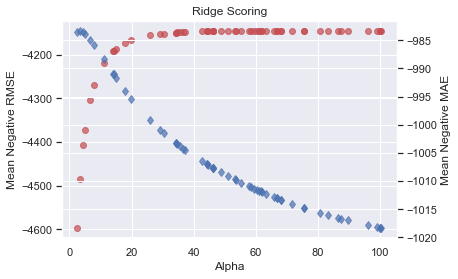

In [18]:
fig, ax = plt.subplots()
ax.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_root_mean_squared_error'], color='r',\
        marker='o', linestyle='none', alpha=0.7)
plt.title('Ridge Scoring')
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Negative RMSE')
ax2 = ax.twinx()
ax2.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_mean_absolute_error'], color='b',\
         marker='d', linestyle='none', alpha=0.7)
ax2.set_ylabel('Mean Negative MAE')
plt.show()

Now that I have an idea of where the optimal alpha value lies for the ridge regression I'll fit an optimized ridge to the train data and add the RMSE to my collection of scores.

In [19]:
ridge=Ridge(alpha=random_ridge.best_params_['alpha'], random_state = 12)
ridge.fit(x_tr, y_tr)
y_pred = ridge.predict(x_te)
train_scores['Ridge'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

35812332.82674365


In [20]:
parameters = {'alpha': sp_randFloat(1,100)}
lasso = linear_model.Lasso(random_state = 12)
rand = RandomizedSearchCV(lasso, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                          refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=0)
rand_lasso = rand.fit(x_tr, y_tr)
rand_lasso.best_params_

{'alpha': 55.88135039273247}

C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000207422145C8> has a label of '_line0' which cannot be automatically added to the legend.
  if sys.path[0] == '':
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000207422D9148> has a label of '_line0' which cannot be automatically added to the legend.
  if sys.path[0] == '':


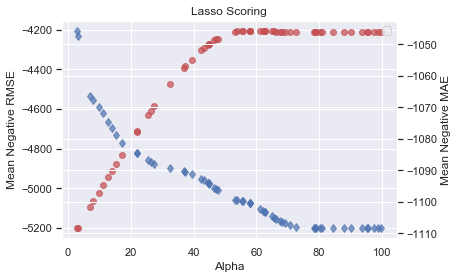

In [22]:
fig, ax = plt.subplots()

a1 = ax.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_root_mean_squared_error'], color='r',\
        marker='o', linestyle='none', alpha=0.7)

ax2 = ax.twinx()
a2 = ax2.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_mean_absolute_error'], color='b',\
         marker='d', linestyle='none', alpha=0.7)

axs = a1+a2
labs = [a.get_label() for a in axs]
ax.legend(axs, labs, loc=0)

plt.title('Lasso Scoring')
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Negative RMSE')
ax2.set_ylabel('Mean Negative MAE')

plt.show()

In [23]:
lasso = linear_model.Lasso(alpha=rand_lasso.best_params_['alpha'], random_state = 12)
lasso.fit(x_tr, y_tr)
y_pred = lasso.predict(x_te)
train_scores['Lasso'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

36148747.86264756


Next will be random forest regression.

In [24]:
parameters = {'max_features': sp_randFloat(0.35, 0.48),
             'max_depth': sp_randInt(6,12),
             'min_samples_leaf': sp_randInt(580,780),
             'n_estimators': sp_randInt(900,1100)
             }
forest = RandomForestRegressor(n_jobs=-1, random_state=12)
forest_reg = RandomizedSearchCV(forest, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
rand_forest = forest_reg.fit(x_tr, y_tr)
rand_forest.best_params_

{'max_depth': 9,
 'max_features': 0.4420211706826668,
 'min_samples_leaf': 585,
 'n_estimators': 965}

In [26]:
opt_forest = RandomForestRegressor(n_estimators=rand_forest.best_params_['n_estimators'],\
                                   max_features=rand_forest.best_params_['max_features'],\
                                   min_samples_leaf=rand_forest.best_params_['min_samples_leaf'],\
                                   max_depth=rand_forest.best_params_['max_depth'], n_jobs = -1, random_state=12)
opt_forest.fit(x_tr, y_tr)
y_pred = opt_forest.predict(x_te)
train_scores['Random Forest'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

35985312.019672506

I'll take a look at XGBoost next to see if it can improve even further. First I need to clean up the column names since XGBoost can't work with some characters. Then I'll run three XGBoost models, one using tree boosters, one using a linear booster with shotgun algorithm, and one using a linear booster with coordinate descent algorithm. 

In [27]:
x_tr.columns = x_tr.columns.str.replace('[', '_')
x_tr.columns = x_tr.columns.str.replace(']', '_')
x_tr.columns = x_tr.columns.str.replace(' ', '_')
x_tr.columns = x_tr.columns.str.replace(',', '_')
x_te.columns = x_te.columns.str.replace('[', '_')
x_te.columns = x_te.columns.str.replace(']', '_')
x_te.columns = x_te.columns.str.replace(' ', '_')
x_te.columns = x_te.columns.str.replace(',', '_')

C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True

In [28]:
xgb = XGBRegressor()
parameters = {'n_estimators': sp_randInt(500,1000),
             'max_depth': sp_randInt(2,10),
             'eta': sp_randFloat(0.0001,0.99),
             'colsample_bytree': sp_randFloat(0.01,0.99)} 
rand_xgb = RandomizedSearchCV(xgb, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=15)
xgbooster = rand_xgb.fit(x_tr, y_tr)
xgbooster.best_params_

{'colsample_bytree': 0.011628310182469744,
 'eta': 0.0711158647674193,
 'max_depth': 9,
 'n_estimators': 860}

In [29]:
xgb_model = XGBRegressor(n_estimators=xgbooster.best_params_['n_estimators'],\
                                   eta=xgbooster.best_params_['eta'],\
                                   colsample_bytree=xgbooster.best_params_['colsample_bytree'],\
                                   max_depth=xgbooster.best_params_['max_depth'])
xgb_model.fit(x_tr, y_tr)
y_pred = xgb_model.predict(x_te)
train_scores['XGBoost'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

36453835.95554887

In [30]:
xgb_linear = XGBRegressor(booster = 'gblinear', verbosity = 0)
parameters = {'reg_lambda': sp_randFloat(0,1),
             'reg_alpha': sp_randFloat(0, 1),
             'feature_selector': ['cyclic', 'shuffle']}
rand_xgb_linear = RandomizedSearchCV(xgb_linear, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
xgbooster_linear = rand_xgb_linear.fit(x_tr, y_tr)
xgbooster_linear.best_params_

{'feature_selector': 'cyclic',
 'reg_alpha': 0.5337393933802977,
 'reg_lambda': 0.014574962485419674}

In [31]:
xgb_model_linear = XGBRegressor(booster = 'gblinear', reg_lambda = xgbooster_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_linear.best_params_['feature_selector'])
xgb_model_linear.fit(x_tr, y_tr)
y_pred = xgb_model_linear.predict(x_te)
train_scores['XGBoost Linear Shotgun'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

35866928.126600765

In [32]:
xgb_coord_desc = XGBRegressor(booster = 'gblinear', updater = 'coord_descent', verbosity = 0)
parameters = {'reg_lambda': sp_randFloat(0,1),
             'reg_alpha': sp_randFloat(0, 1),
             'feature_selector': ['random', 'greedy', 'thrifty']}
rand_xgb_cd = RandomizedSearchCV(xgb_coord_desc, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
xgbooster_linear_cd = rand_xgb_cd.fit(x_tr, y_tr)
xgbooster_linear_cd.best_params_

{'feature_selector': 'random',
 'reg_alpha': 0.7258614974313065,
 'reg_lambda': 0.014498616011217602}

In [33]:
xgb_model_lcd = XGBRegressor(booster = 'gblinear', updater = 'coord_descent',\
                                reg_lambda = xgbooster_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_linear.best_params_['feature_selector'])
xgb_model_lcd.fit(x_tr, y_tr)
y_pred = xgb_model_lcd.predict(x_te)
train_scores['XGBoost Linear Coord Descent'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

35866460.72783456

Next will be a more basic decision tree.

In [34]:
d_tree = tree.DecisionTreeRegressor(random_state = 12)
parameters = {'max_depth': sp_randInt(2,10),
             'min_samples_leaf': sp_randInt(100,5000)}
rand_tree = RandomizedSearchCV(d_tree, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
decision_tree = rand_tree.fit(x_tr, y_tr)
decision_tree.best_params_

{'max_depth': 3, 'min_samples_leaf': 518}

In [35]:
decision_tree_model = tree.DecisionTreeRegressor(max_depth = decision_tree.best_params_['max_depth'],\
                                            min_samples_leaf = decision_tree.best_params_['min_samples_leaf'],\
                                            random_state = 12)
decision_tree_model.fit(x_tr, y_tr)
y_pred = decision_tree_model.predict(x_te)
train_scores['Decision Tree'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

36053452.74061726

Finally I'll look at K nearest neighbors and then LGBM

In [36]:
neighbors = KNeighborsRegressor()
parameters = {'n_neighbors': sp_randInt(2,50)}
rand_knn = RandomizedSearchCV(neighbors, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=12)
opt_nn = rand_knn.fit(x_tr, y_tr)
opt_nn.best_params_

{'n_neighbors': 36}

In [37]:
knn_opt = KNeighborsRegressor(n_neighbors = opt_nn.best_params_['n_neighbors'])
knn_opt.fit(x_tr, y_tr)
y_pred = knn_opt.predict(x_te)
train_scores['KNN'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

36030817.05017025

In [38]:
lgbm = lgb.LGBMRegressor(objective = 'regression', metric = 'mae')
parameters = {'num_leaves': sp_randInt(10,1000),
              'n_estimators': sp_randInt(10,1000),
              'max_depth': sp_randInt(2,10),
              'learning_rate': sp_randFloat(0.001,1)}
rand_lgbm = RandomizedSearchCV(lgbm, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
opt_lgbm = rand_lgbm.fit(x_tr, y_tr)
opt_lgbm.best_params_

{'learning_rate': 0.08298980249791144,
 'max_depth': 2,
 'n_estimators': 893,
 'num_leaves': 219}

In [39]:
lgbm_opt = lgb.LGBMRegressor(objective = 'regression', metric = 'mae', num_leaves = opt_lgbm.best_params_['num_leaves'],\
                             n_estimators = opt_lgbm.best_params_['n_estimators'],\
                             max_depth = opt_lgbm.best_params_['max_depth'],\
                             learning_rate = opt_lgbm.best_params_['learning_rate'])
lgbm_opt.fit(x_tr, y_tr)
y_pred = lgbm_opt.predict(x_te)
train_scores['Light GBM'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

35929524.309228405

Now that I've done a quick once-over for these different models let's take a look at which performed the best so far and by how much.

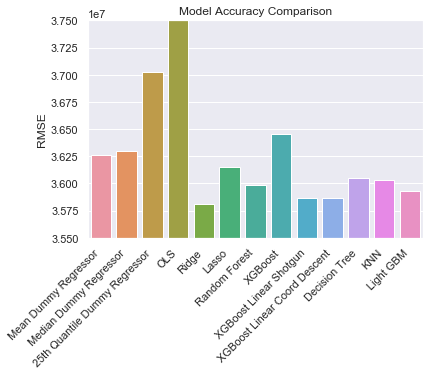

In [48]:
keys = list(train_scores.keys())
vals = [float(train_scores[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE')
plt.ylim(35500000,37500000)
plt.title('Model Accuracy Comparison')
plt.show()

I'll also list out the values in order.

In [47]:
[(k, v) for k, v in sorted(train_scores.items(), key=lambda x: x[1], reverse=False)]

[('Ridge', 35812332.82674365),
 ('XGBoost Linear Coord Descent', 35866460.72783456),
 ('XGBoost Linear Shotgun', 35866928.126600765),
 ('Light GBM', 35929524.309228405),
 ('Random Forest', 35985312.019672506),
 ('KNN', 36030817.05017025),
 ('Decision Tree', 36053452.74061726),
 ('Lasso', 36148747.86264756),
 ('Mean Dummy Regressor', 36263761.69940872),
 ('Median Dummy Regressor', 36294646.32369107),
 ('XGBoost', 36453835.95554887),
 ('25th Quantile Dummy Regressor', 37025295.57501316),
 ('OLS', 3.1926184945949468e+16)]

Now I need to hone in on those top few models to see which really stands out as I work on improving them. I'll start by rerunning them with 80% training data splits using the same hyperparameters identified in this first section.

In [50]:
x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2)
y_tr = y_tr.values.ravel()
y_te = y_te.values.ravel()
x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((124953, 400), (31239, 400), (124953,), (31239,))

In [56]:
train_scores_2 = {}
ridge=Ridge(alpha=random_ridge.best_params_['alpha'], random_state = 12)
ridge.fit(x_tr, y_tr)
y_pred = ridge.predict(x_te)
train_scores_2['Ridge'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

4989646.12493043


In [53]:
x_tr.columns = x_tr.columns.str.replace('[', '_')
x_tr.columns = x_tr.columns.str.replace(']', '_')
x_tr.columns = x_tr.columns.str.replace(' ', '_')
x_tr.columns = x_tr.columns.str.replace(',', '_')
x_te.columns = x_te.columns.str.replace('[', '_')
x_te.columns = x_te.columns.str.replace(']', '_')
x_te.columns = x_te.columns.str.replace(' ', '_')
x_te.columns = x_te.columns.str.replace(',', '_')

C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True

In [64]:
xgb_model_lcd = XGBRegressor(booster = 'gblinear', updater = 'coord_descent',\
                                reg_lambda = xgbooster_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_linear.best_params_['feature_selector'])
xgb_model_lcd.fit(x_tr, y_tr)
y_pred = xgb_model_lcd.predict(x_te)
train_scores_2['XGBoost Linear Coord Descent'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

5122470.266931484

In [65]:
xgb_model_linear = XGBRegressor(booster = 'gblinear', reg_lambda = xgbooster_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_linear.best_params_['feature_selector'])
xgb_model_linear.fit(x_tr, y_tr)
y_pred = xgb_model_linear.predict(x_te)
train_scores_2['XGBoost Linear Shotgun'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

5122626.455583302

In [57]:
lgbm_opt = lgb.LGBMRegressor(objective = 'regression', metric = 'mae', num_leaves = opt_lgbm.best_params_['num_leaves'],\
                             n_estimators = opt_lgbm.best_params_['n_estimators'],\
                             max_depth = opt_lgbm.best_params_['max_depth'],\
                             learning_rate = opt_lgbm.best_params_['learning_rate'])
lgbm_opt.fit(x_tr, y_tr)
y_pred = lgbm_opt.predict(x_te)
train_scores_2['Light GBM'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

4970398.387145526

In [58]:
opt_forest = RandomForestRegressor(n_estimators=rand_forest.best_params_['n_estimators'],\
                                   max_features=rand_forest.best_params_['max_features'],\
                                   min_samples_leaf=rand_forest.best_params_['min_samples_leaf'],\
                                   max_depth=rand_forest.best_params_['max_depth'], n_jobs = -1, random_state=12)
opt_forest.fit(x_tr, y_tr)
y_pred = opt_forest.predict(x_te)
train_scores_2['Random Forest'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

5054208.105365566

In [59]:
knn_opt = KNeighborsRegressor(n_neighbors = opt_nn.best_params_['n_neighbors'])
knn_opt.fit(x_tr, y_tr)
y_pred = knn_opt.predict(x_te)
train_scores_2['KNN'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

5208049.076257908

In [60]:
decision_tree_model = tree.DecisionTreeRegressor(max_depth = decision_tree.best_params_['max_depth'],\
                                            min_samples_leaf = decision_tree.best_params_['min_samples_leaf'],\
                                            random_state = 12)
decision_tree_model.fit(x_tr, y_tr)
y_pred = decision_tree_model.predict(x_te)
train_scores_2['Decision Tree'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

5316602.137613924

In [61]:
lasso = linear_model.Lasso(alpha=rand_lasso.best_params_['alpha'], random_state = 12)
lasso.fit(x_tr, y_tr)
y_pred = lasso.predict(x_te)
train_scores_2['Lasso'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

5454716.721421391


In [67]:
xgb_model = XGBRegressor(n_estimators=xgbooster.best_params_['n_estimators'],\
                                   eta=xgbooster.best_params_['eta'],\
                                   colsample_bytree=xgbooster.best_params_['colsample_bytree'],\
                                   max_depth=xgbooster.best_params_['max_depth'])
xgb_model.fit(x_tr, y_tr)
y_pred = xgb_model.predict(x_te)
train_scores_2['XGBoost'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

4968646.873173527

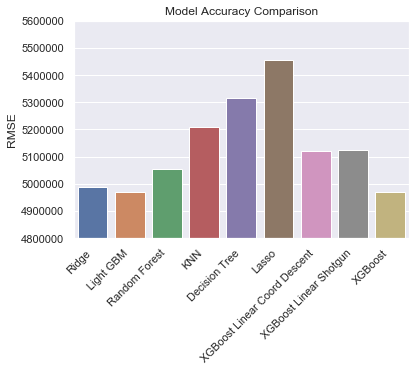

In [68]:
keys = list(train_scores_2.keys())
vals = [float(train_scores_2[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE')
plt.ylim(4800000,5600000)
plt.title('Model Accuracy Comparison')
plt.show()

Wow, ridge is holding up as one of the best models we have for this data! I'll redo the hyperparameter tuning at this higher train-test split on just ridge, light GBM, and XGBoost to try to improve them and see if I can further narrow down to a single model worth finalizing.

In [70]:
train_scores_3 = {}
parameters = {'alpha': sp_randFloat(2,100)}
ridge = Ridge(random_state = 12)
ridge_reg = RandomizedSearchCV(ridge, parameters,scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                               refit='neg_root_mean_squared_error', n_iter=60, cv=5)
random_ridge = ridge_reg.fit(x_tr, y_tr)
y_pred = random_ridge.predict(x_te)
train_scores_3['Ridge'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

4988475.365503406


In [71]:
xgb = XGBRegressor()
parameters = {'n_estimators': sp_randInt(500,1000),
             'max_depth': sp_randInt(2,10),
             'eta': sp_randFloat(0.0001,0.99),
             'colsample_bytree': sp_randFloat(0.01,0.99)} 
rand_xgb = RandomizedSearchCV(xgb, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=15)
xgbooster = rand_xgb.fit(x_tr, y_tr)
y_pred = xgbooster.predict(x_te)
train_scores_3['XGBoost'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

4968646.873173527

In [72]:
lgbm = lgb.LGBMRegressor(objective = 'regression', metric = 'mae')
parameters = {'num_leaves': sp_randInt(10,1000),
              'n_estimators': sp_randInt(10,1000),
              'max_depth': sp_randInt(2,10),
              'learning_rate': sp_randFloat(0.001,1)}
rand_lgbm = RandomizedSearchCV(lgbm, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
opt_lgbm = rand_lgbm.fit(x_tr, y_tr)
y_pred = opt_lgbm.predict(x_te)
train_scores_3['Light GBM'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

4970398.387145526

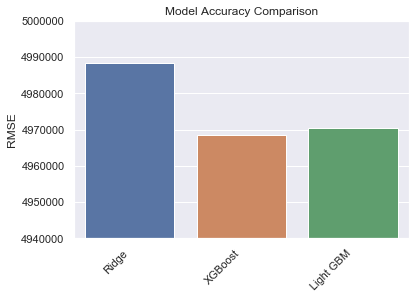

In [74]:
keys = list(train_scores_3.keys())
vals = [float(train_scores_3[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE')
plt.ylim(4940000,5000000)
plt.title('Model Accuracy Comparison')
plt.show()

So it looks like ridge plateaus around 4.98M RMSE and we're safe to stop pushing it any further. XGBoost performs the best of the three, though it's a very close call against Light GBM. I will go ahead and take a look now at XGBoost to see if I hold these hyperparameters but add extra data to the train set will it significantly boost the performance at all.

In [83]:
X_train.columns = X_train.columns.str.replace('[', '_')
X_train.columns = X_train.columns.str.replace(']', '_')
X_train.columns = X_train.columns.str.replace(' ', '_')
X_train.columns = X_train.columns.str.replace(',', '_')

C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [84]:
split_ratios = {}

ratios = [0.2, 0.175, 0.15, 0.125, 0.1, 0.075, 0.05]

for ratio in ratios:
    x_train, x_test, y_tra, y_test = train_test_split(X_train, y_train, test_size = ratio)
    y_tra = y_tra.values.ravel()
    y_test = y_test.values.ravel()
    
    xgb = XGBRegressor(n_estimators = xgbooster.best_params_['n_estimators'], 
                       max_depth = xgbooster.best_params_['max_depth'], 
                       eta = xgbooster.best_params_['eta'],
                  colsample_bytree = xgbooster.best_params_['colsample_bytree']) 
    xgb.fit(x_train, y_tra)
    y_pred = xgb.predict(x_test)
    
    split_ratios[ratio] = mean_squared_error(y_test, y_pred)

In [87]:
splits = pd.DataFrame(data = split_ratios, index=['RMSE']).T

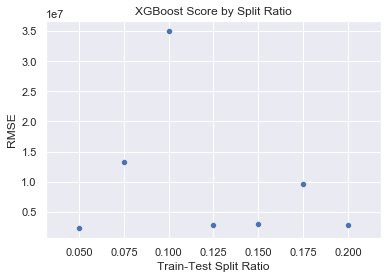

The lowest RMSE achieved was:  2254354.528163833
The split ratio for this RSME was:  RMSE    0.05
dtype: float64


In [123]:
sns.scatterplot(data = splits, x=splits.index, y=splits['RMSE'])
plt.ylabel('RMSE')
plt.xlabel('Train-Test Split Ratio')
plt.title('XGBoost Score by Split Ratio')
plt.show()
print('The lowest RMSE achieved was: ', min(splits['RMSE']))
print('The split ratio for this RSME was: ', splits[['RMSE']].idxmin())

Well that's not what I expected. I expected to see a downward trend with an elbow where more data doesn't improve the score any further. This suggests to me that there may be a few outliers in the data that increase the RMSE dramatically if they're not included in the test set. To test this I'll do a 10% training split, plot predicted y_test against actual y_test, and check for outliers.

In [89]:
x_train, x_test, y_tra, y_test = train_test_split(X_train, y_train, test_size = 0.9)

xgb = XGBRegressor(n_estimators = xgbooster.best_params_['n_estimators'], 
                       max_depth = xgbooster.best_params_['max_depth'], 
                       eta = xgbooster.best_params_['eta'],
                  colsample_bytree = xgbooster.best_params_['colsample_bytree']) 
xgb.fit(x_train, y_tra)
y_pred = xgb.predict(x_test)
mean_squared_error(y_test, y_pred)

39339862.88597387

[]

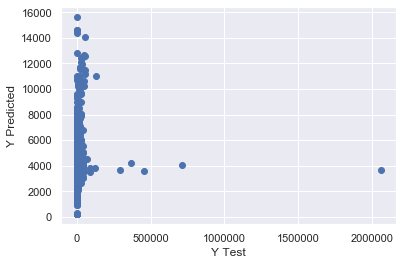

In [91]:
plt.plot(y_test, y_pred, marker='o', linestyle='')
plt.xlabel('Y Test')
plt.ylabel('Y Predicted')
plt.plot()

Ok, this shows what I expected to see, there are 5 outliers that have 2-10x worse predictions than the rest of the data, and if they're not in the training data then they increase the RMSE of the model significantly.

For now I'll just acknowledge this aspect of the data and proceed by seeing if I reduce the number of features in the data to just those deemed important by my best ridge model, can that improve the performance of my current best XGBoost model? I'll keep my train split at 80% of the data since any improvements below that seem to be marginal, assuming those outliers are in the train set.

In [95]:
from sklearn.feature_selection import SelectFromModel

In [105]:
x_train, x_test, y_tra, y_test = train_test_split(X_train, y_train, test_size = 0.2)

selector = SelectFromModel(estimator = Ridge(alpha = random_ridge.best_params_['alpha'], random_state = 12)).fit(x_train, y_tra)

In [111]:
X_train_ridge = X_train.loc[:, selector.get_support()]
X_train_ridge.shape

(156192, 139)

In [112]:
x_train, x_test, y_tra, y_test = train_test_split(X_train_ridge, y_train, test_size = 0.2)

In [113]:
xgb_r = XGBRegressor()
parameters = {'n_estimators': sp_randInt(500,1000),
             'max_depth': sp_randInt(2,10),
             'eta': sp_randFloat(0.0001,0.99),
             'colsample_bytree': sp_randFloat(0.01,0.99)} 
ridge_xgb = RandomizedSearchCV(xgb_r, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=15)
xgbr = ridge_xgb.fit(x_train, y_tra)
y_pred = xgbr.predict(x_test)
train_scores_3['XGBoost'] = mean_squared_error(y_test, y_pred)
mean_squared_error(y_test, y_pred)

2945212.966352341

In [116]:
rmse_dict = {'ridge_data_rmse': mean_squared_error(y_test, y_pred), 'full_data_rmse': min(splits['RMSE'])}

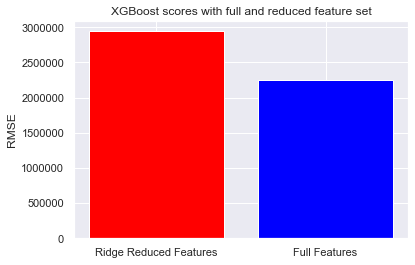

In [122]:
plt.bar(range(len(rmse_dict)), list(rmse_dict.values()), tick_label=['Ridge Reduced Features', 'Full Features'],\
        color=['red', 'blue'])
plt.ylabel('RMSE')
plt.title('XGBoost scores with full and reduced feature set')
plt.show()

Ok, so now I know that my current best model uses the full 400 features I began with, and that reducing the features based on those the ridge model kept hurts the XGBoost performance. 


To wrap up I'll take a look at feature importance in the model based on the full data to see how it aligns with what I identified during exploratory data analysis.

First I'll need to do one final smaller hyperparameter search since the previous models were overwritten during the train-test splitting when I hit that 2.3M RMSE model.

In [126]:
print('n_estimators: ', xgbooster.best_params_['n_estimators'])
print('max_depth: ', xgbooster.best_params_['max_depth'])
print('eta: ', xgbooster.best_params_['eta'])
print('colsample_bytree: ', xgbooster.best_params_['colsample_bytree'])

n_estimators:  860
max_depth:  9
eta:  0.0711158647674193
colsample_bytree:  0.011628310182469744


In [127]:
x_train, x_test, y_tra, y_test = train_test_split(X_train, y_train, test_size = 0.2)
y_tra = y_tra.values.ravel()
y_test = y_test.values.ravel()
    
xgbr = XGBRegressor()
parameters = {'n_estimators': sp_randInt(820,900),
             'max_depth': sp_randInt(7,11),
             'eta': sp_randFloat(0.05,0.09),
             'colsample_bytree': sp_randFloat(0.001,0.1)} 
xgb_opt = RandomizedSearchCV(xgbr, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=10, cv=5, random_state=15)
xgb_opt.fit(x_train, y_tra)
y_pred = xgb_opt.predict(x_test)
mean_squared_error(y_test, y_pred)

2918447.9209540263

In [128]:
x_train, x_test, y_tra, y_test = train_test_split(X_train, y_train, test_size = 0.05)
y_tra = y_tra.values.ravel()
y_test = y_test.values.ravel()
    
xgbr = XGBRegressor()
parameters = {'n_estimators': sp_randInt(820,900),
             'max_depth': sp_randInt(7,11),
             'eta': sp_randFloat(0.05,0.09),
             'colsample_bytree': sp_randFloat(0.001,0.1)} 
xgb_opt = RandomizedSearchCV(xgbr, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=10, cv=5, random_state=15)
xgb_opt.fit(x_train, y_tra)
y_pred = xgb_opt.predict(x_test)
mean_squared_error(y_test, y_pred)

2071672.0284194604

In [132]:
booster = XGBRegressor(n_estimators = xgb_opt.best_params_['n_estimators'],
                      max_depth = xgb_opt.best_params_['max_depth'],
                      eta = xgb_opt.best_params_['eta'],
                      colsample_bytree = xgb_opt.best_params_['colsample_bytree']).fit(x_train, y_tra)
y_pred = booster.predict(x_test)
mean_squared_error(y_test, y_pred)

2071672.0284194604

As one final test I'm going to load in all four dataframes from the feature engineering notebook: X train and test, as well as Y train and test. I'll train the final XGBoost regressor on the train data and test it on the test sets which to this point haven't even been loaded into this notebook. That will be my final assessment of the model RMSE.

In [4]:
x_train_final = pd.read_csv('X_train.csv', index_col=0)
x_test_final = pd.read_csv('y_train.csv', index_col=0)
y_train_final = pd.read_csv('X_test.csv', index_col=0)
y_test_final = pd.read_csv('y_test.csv', index_col=0)

In [ ]:
booster = XGBRegressor(n_estimators = xgb_opt.best_params_['n_estimators'],
                      max_depth = xgb_opt.best_params_['max_depth'],
                      eta = xgb_opt.best_params_['eta'],
                      colsample_bytree = xgb_opt.best_params_['colsample_bytree']).fit(x_train_final, y_train_final)
y_pred_final = booster.predict(x_test_final)
mean_squared_error(y_test_final, y_pred_final)

## Conclusions

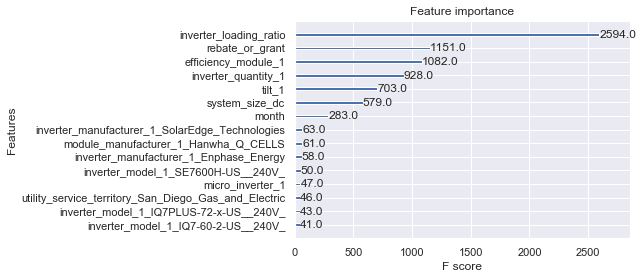

In [133]:
xgboost.plot_importance(booster = booster, max_num_features = 15)

This is very interesting, it looks like most of the top features used in this XGBoost model are related to the inverter - specifically the loading ratio, manufacturer, and model. Revisiting my exploratory data analysis shows that there was a significant negative correlation between inverter loading ratio and price per KW, shown below:

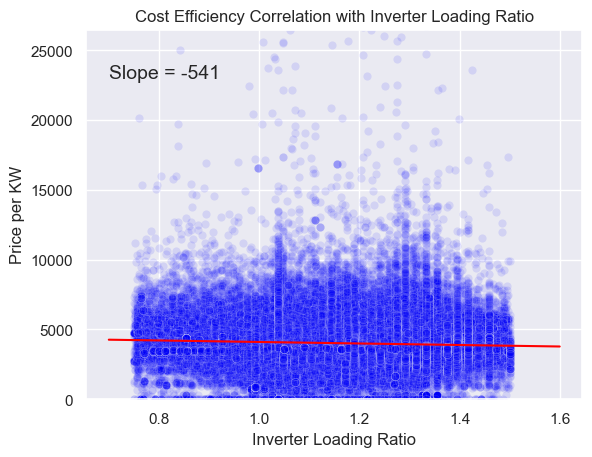

The inverter loading ratio represents the maximum amount of DC current produced by the solar panels - directly correlated to the area of panels installed - vs the AC inverter capacity. Since solar energy is produced as DC current, the inverter is needed to transform that to AC so it can be used on the US power grid. Since the panels will only experience peak performance for a brief window during the day, it is common to install more panels than the inverter can handle at peak (called inverter clipping), so that during off hours those extra panels can still contribute. A diagram below shows this concept more clearly:
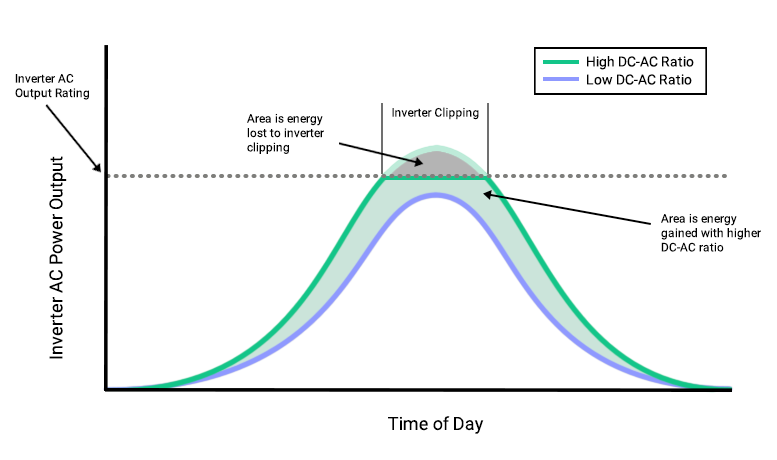
Source: https://aurorasolar.com/blog/choosing-the-right-size-inverter-for-your-solar-design-a-primer-on-inverter-clipping/

By installing a higher inverter loading ratio, the customer will produce more solar electricity throughout the day while keeping their inverter cost down, so it makes sense that this has a large impact on the overall cost efficiency of an installation.

The next most important feature was whether a rebate or grant was obtained which makes obvious sense given that applying a rebate or grant will directly lower the cost of the installation and hence improve cost efficiency.

The efficiency of the photovoltaic module was the next most important feature, which I find interesting because it seemed to have a relatively small (though significant) impact on cost efficiency. As shown in the image from my exploratory data analysis, the slope is very slightly positive, suggesting that as efficiency of the module increases, cost per KW increases as well, hurting cost efficiency.
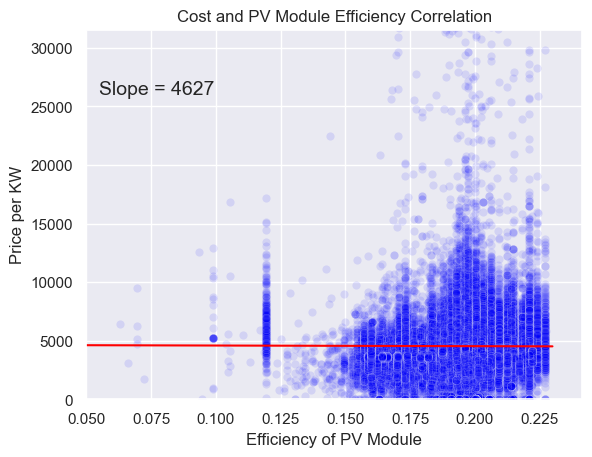

Inverter quantity 1 was the next most important feature, showing a clear correlation between larger inverters and lower cost per KW.
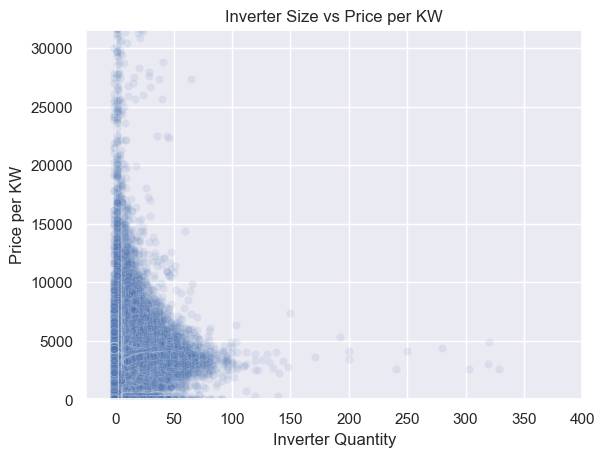

This is interesting because when taken along with the inverter ratio findings it suggests that to optimize cost efficiency the customer wants a large inverter with even more solar panels than that inverter can handle.

Tilt is an interesting feature. Tilt refers to the angle of the panel relative to the ground as shown here:
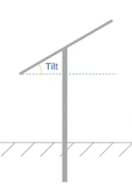
Source: https://ratedpower.com/blog/pv-panel-tilt/

What makes this feature interesting is that there are some commonly used angles which have much larger ranges of cost efficiency than the uncommonly used angles.
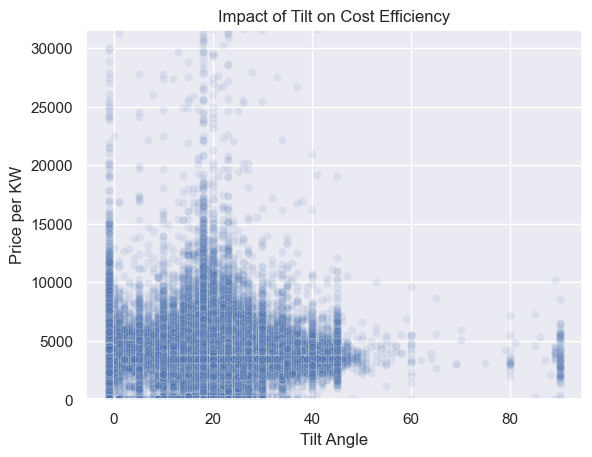

Does this mean that if you install your solar panel tilted at 7&deg; rather than 10&deg; your solar panel installation will be cheaper? I doubt it. There's likely some correlation between tilt and another factor not captured in my dataset that explains this observation, possibly even just that there are more installations at those major angles which provides more opportunity for high price per KW values to occur. 

System size was the next most important feature and much like inverter size, shows a correlation between larger system size and lower cost per KW.
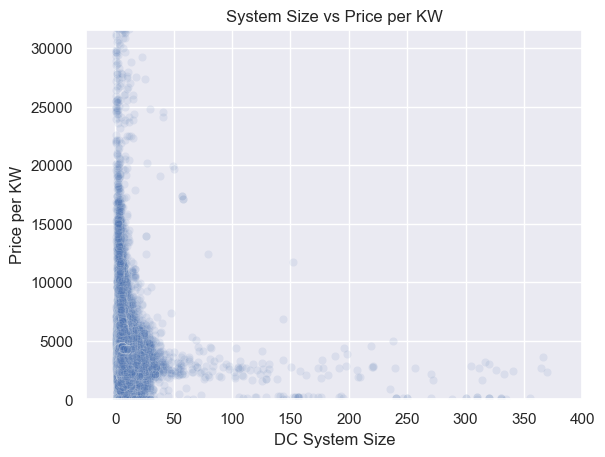

The last feature that was used for more than 100 splits in the boosted algorithm was the month of installation. Chi squared testing showed significant correlation between month and cost efficiency, and a visual representation of the data is shown below:
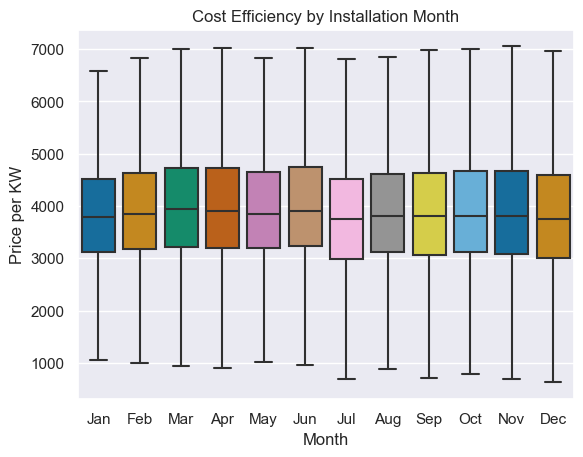

A quick look suggests that installations in July and December may be cheaper on average than other months and could save the customer some money.